### Table of Contents

* [Introduction](#chapter0)
* [Step 1](#chapter1)
    * [read file](#section_1_1)
* [Step 2](#chapter2)
    * [Preparing data](#section_2_1)
    * [Date and time](#section_2_2)  
* [Step 3](#chapter3)
    * [Number events/users are in the logs](#section_3_1)
    * [Average number of events per user](#section_3_2)
    * [Period of time the data covers](#section_3_3)
* [Step 4](#chapter4)
    * [Users proportion in each action](#section_4_1)
    * [Action sequence](#section_4_2)
    * [Share of users that proceed in each level](#section_4_3)
    * [The largest amount of users was stop the progress](#section_4_4)
    * [Share of users who make the whole jorney](#section_4_5)
* [Step 5](#chapter5)
    * [Number of users in the test](#section_5_1)
    * [Difference between two control groups](#section_5_2)
    * [test group with first control group](#section_5_3)
    * [test group with second control group](#section_5_4)
* [Results](#chapter6)  

In [1]:
#pip install seaborn==0.11

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math 
import datetime
from datetime import datetime
from scipy import stats 
#from pandas.tseries import converter
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In C:\Users\MiriHad\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MiriHad\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MiriHad\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\MiriHad\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MiriHad\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classi

# Introduction <a class="anchor" id="chapter0"></a>

We working in startup that sells food products. We have two major goals. First, we will investigate users behaviour using funnels. Next, we will explore an A/B test results for new font change in the app. 


# Step 1 <a class="anchor" id="chapter1"></a>

## read file <a class="anchor" id="section_1_1"></a>

In [3]:
df = pd.read_csv('logs_exp_us.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.tail()

,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


In [5]:
df.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
85682,CartScreenAppear,9182444363400946277,1564827742,247
99556,MainScreenAppear,5652408908145908323,1564848893,246
159297,MainScreenAppear,8804677061169353479,1565011667,246
175449,MainScreenAppear,3629479115578224564,1565037064,248
129877,CartScreenAppear,837505346045732408,1564932157,246


In [6]:
df.EventName.value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

# Step 2 <a class="anchor" id="chapter2"></a>

## Preparing data for analysis <a class="anchor" id="section_2_1"></a>

In [7]:
#changing column names
df.columns = ['event_name', 'user_id', 'event_time', 'exp_number']
#experiment number: 246 and 247 are the control groups, 248 is the test groupInstructions for completing the project

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   exp_number  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [9]:
df.shape

(244126, 4)

In [10]:
#missing values + more info
df.isnull().sum()


event_name    0
user_id       0
event_time    0
exp_number    0
dtype: int64

In [11]:
for i in df.columns:    
    print(i, len(df[df[i]==0]))

event_name 0
user_id 0
event_time 0
exp_number 0


In [12]:
#duplicates
df.duplicated().sum()


413

In [13]:
#drop duplicates
df.drop_duplicates(inplace=True)

* There are 243713 rows initialy and 4 columns
* We changed the column names.
* There were 413 duplicates that was dropped.(currently 243300 rows) There are no longer duplicated rows. 
* No missing values were found.


## Date and time <a class="anchor" id="section_2_2"></a>

 In our data we have an unix time format, which gives the number of seconds that have passed since 00:00:00 on January 1st, 1970. Therefor we will use to_datetime and transfer in seconds (unit='s')

In [14]:
#ordering the date column:
df.event_time = pd.to_datetime(df.event_time, unit='s')

In [15]:
# separating time and date:
df['date'] = df.event_time.dt.date
df['time'] = df.event_time.dt.time

# Step 3 <a class="anchor" id="chapter3"></a>

## Number events/users are in the logs <a class="anchor" id="section_3_1"></a>

In [16]:
#number of events in logs:
df['event_name'].nunique()

5

In [17]:
#number of users in logs:
df['user_id'].nunique()

7551

## Average number of events per user <a class="anchor" id="section_3_2"></a>

In [18]:
#number of events per user
#average number of events per user
df.groupby('user_id')['event_name'].count().reset_index()['event_name'].mean()


32.27559263673685

We calculated the nmber of events per user. then we calculated the total average number of events per user.

In [19]:
#how many people made the full circle = stage number 4 .
df.groupby(['user_id'])['event_name'].nunique().reset_index().groupby('event_name')['user_id'].nunique()

event_name
1    2707
2    1021
3     317
4    3035
5     471
Name: user_id, dtype: int64

* First we calculated the unique number of events each costomer did. Then, we groupes by number of events to see the number of users in each unique event. 
* With this action we split the total (7551) users into events they did. 
* It means that 3035 users made the full circle

## Period of time the data covers <a class="anchor" id="section_3_3"></a>

In [20]:
df.head()

,event_name,user_id,event_time,exp_number,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [21]:
#min time
df['event_time'].min()

Timestamp('2019-07-25 04:43:36')

In [22]:
#max time
df['event_time'].max()

Timestamp('2019-08-07 21:15:17')

The whole tracking began on 2019-07-25 04:43:36 and was ended on 2019-08-07 21:15:17.

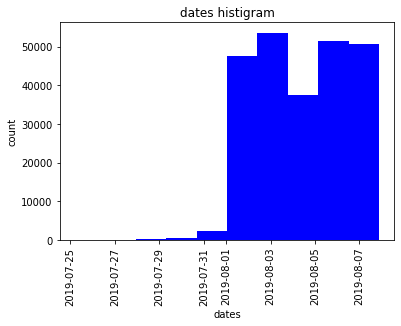

In [23]:
#plt.figure(figsize=(8,5), dpi=100)

plt.hist(df['event_time'], bins=10, color='blue')
plt.ylabel('count')
plt.xlabel('dates')
plt.title('dates histigram')
plt.xticks(rotation='vertical')
plt.show()

Its seems that the actuall data doesn't starts as we expected. Lets see if when we divide by event we will see somethind else.

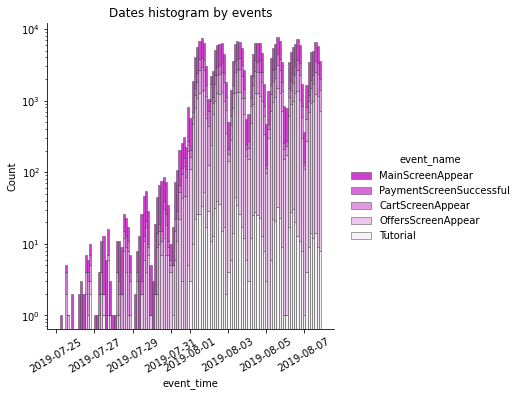

In [24]:
s = sns.displot(
    df,
    x="event_time", hue="event_name",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)
plt.title('Dates histogram by events')

s.set(yscale="log")
s.set_xticklabels(rotation=30)

After watching the histogram its clearly seen that the actuall start date was on 1.8.2019 and until 7.8.2019 (one week total).

In [25]:
new_df = df[df['event_time'] >= '2019-08-01 00:00:00']
new_df.head()

,event_name,user_id,event_time,exp_number,date,time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [26]:
new_df.shape

(240887, 6)

We had 243,300 rows before. Now we have 240,887 rows. 

In [27]:
#cheking the experiment groups 
new_df.exp_number.value_counts()

248    84563
246    79302
247    77022
Name: exp_number, dtype: int64

The 3 experimental groups are presented. 

We have a new data(new df). We will calculate again the number of users, average and the stage they made:

In [28]:
new_df.user_id.nunique()

7534

In [29]:
new_df.groupby('user_id')['event_name'].count().reset_index()['event_name'].mean()

31.97332094504911

In [30]:
#how many people made the full circle = stage number 4 .
new_df.groupby(['user_id'])['event_name'].nunique().reset_index().groupby('event_name')['user_id'].nunique()

event_name
1    2717
2    1004
3     318
4    3029
5     466
Name: user_id, dtype: int64

* looking the data we saw that though the period of the data is two weeks, actualy the test duration is only a week . 
* The average number of events per user in the clean data is 31.97.
* We have 7534 users total, but those who finished the whole circle are 3029.

# Step 4 <a class="anchor" id="chapter4"></a>

##  Users proportion in each action<a class="anchor" id="section_4_1"></a>

In [31]:
new_df.sample(5)

,event_name,user_id,event_time,exp_number,date,time
42545,MainScreenAppear,5337150047897686372,2019-08-02 04:40:18,246,2019-08-02,04:40:18
99018,OffersScreenAppear,1524322915255226164,2019-08-03 16:00:37,247,2019-08-03,16:00:37
196755,OffersScreenAppear,6875369516670876232,2019-08-06 13:58:34,248,2019-08-06,13:58:34
197021,MainScreenAppear,430050972528078970,2019-08-06 14:02:38,248,2019-08-06,14:02:38
31646,MainScreenAppear,5496577668139009568,2019-08-01 17:30:06,246,2019-08-01,17:30:06


In [32]:
# event frequency
ev_freq = new_df.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()
ev_freq.columns = ['event_name', 'events']
ev_freq

,event_name,events
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [33]:
# number of users on each stage
usr_cnt = new_df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
usr_cnt.columns = ['event_name', 'users']
usr_cnt

,event_name,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [34]:
users = usr_cnt.merge(ev_freq, on='event_name')


In [35]:
#those who perform an action at least once
users['proportion'] = users.users / new_df.user_id.nunique()
users


,event_name,users,events,proportion
0,MainScreenAppear,7419,117328,0.984736
1,OffersScreenAppear,4593,46333,0.609636
2,CartScreenAppear,3734,42303,0.495620
3,PaymentScreenSuccessful,3539,33918,0.469737
4,Tutorial,840,1005,0.111495


The "proportion" column shows the number of users who made a certain step in compere with the total number of users in the test .

In [36]:
# or anastasias explanation  :  for more that one : 

at_least_once = new_df.groupby(['user_id','event_name'])['event_time'].count().reset_index()

In [37]:
# or anastasias explanation  :  for more that one : 
(
    at_least_once[at_least_once.event_time >= 2]
    .groupby('event_name')['user_id'].nunique().sort_values(ascending=False) / 
    new_df.groupby('event_name')['user_id'].nunique()
)

event_name
CartScreenAppear           0.873594
MainScreenAppear           0.966842
OffersScreenAppear         0.851731
PaymentScreenSuccessful    0.837807
Tutorial                   0.100000
Name: user_id, dtype: float64

* of those who made at least once, who made the second time . 
* It means that 46% was PaymentScreenSuccessful once , and 83% twice.   
* Its like a retension for out funnel

In [38]:
users_proportion = users[['event_name', 'proportion']]
users_proportion

,event_name,proportion
0,MainScreenAppear,0.984736
1,OffersScreenAppear,0.609636
2,CartScreenAppear,0.495620
3,PaymentScreenSuccessful,0.469737
4,Tutorial,0.111495


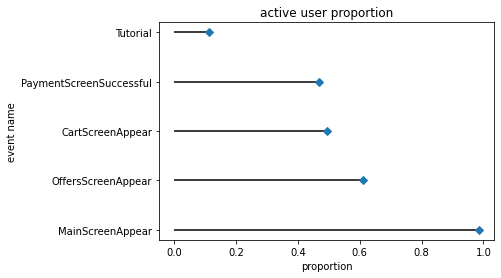

In [39]:

my_range=range(1,len(users_proportion.index)+1)


plt.hlines(y=my_range, xmin=0, xmax=users_proportion['proportion'], color='black')
plt.plot(users_proportion['proportion'], my_range, "D")
plt.yticks(my_range, users_proportion['event_name'])
plt.title('active user proportion')
plt.ylabel('event name')
plt.xlabel('proportion')
plt.show()




##  Action Order<a class="anchor" id="section_4_2"></a> 

To answer the question does the action are part of the same sequence we need to look in a different direction . We will use the dates and see the number of the actuall sequence.

In [40]:
users_pivot = new_df.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='event_time',
    aggfunc='min') 
users_pivot.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


In [41]:
# looking activity that was part of a sequence
step_1 = ~users_pivot['MainScreenAppear'].isna()
step_2 = step_1 & (users_pivot['OffersScreenAppear'] > users_pivot['MainScreenAppear'])
step_3 = step_2 & (users_pivot['CartScreenAppear'] > users_pivot['OffersScreenAppear'])
step_4 = step_3 & (users_pivot['PaymentScreenSuccessful'] > users_pivot['CartScreenAppear'])

n_pageview = users_pivot[step_1].shape[0]
n_add_to_cart = users_pivot[step_2].shape[0]
n_checkout = users_pivot[step_3].shape[0]
n_payment = users_pivot[step_4].shape[0]

print('Visitors:', n_pageview)
print('Offers Screen Appear:', n_add_to_cart)
print('Cart Screen Appear:', n_checkout)
print('Paid:', n_payment)

Visitors: 7419
Offers Screen Appear: 4201
Cart Screen Appear: 1767
Paid: 454


* As we see the numbers are differen from those in the users table. It means there were people that wasn't using the "logical" activity order.
* In addition tutorial phase isn't part of the "logical" sequence.

In [42]:
users = users.drop(4)

* Action Order :  The order is : MainScreenAppear -> OffersScreenAppear -> CartScreenAppear-> PaymentScreenSuccessful. 
* The tutorial isn't part of the sequence and can happened any time during the stay in the web site.
* The tutorial category was droped.

##  Share of users that proceed in each level<a class="anchor" id="section_4_3"></a>

We will use the users information because we don't need to take the sequence into account (question instructions)

In [43]:
users

,event_name,users,events,proportion
0,MainScreenAppear,7419,117328,0.984736
1,OffersScreenAppear,4593,46333,0.609636
2,CartScreenAppear,3734,42303,0.495620
3,PaymentScreenSuccessful,3539,33918,0.469737


In [44]:
users2 = users[['event_name', 'users']]

In [45]:
first_step = users2['users'][1] / users2['users'][0] * 100
first_step

61.908613020622724

In [46]:
second_step = users2['users'][2] / users2['users'][1] * 100
second_step

81.29762682342695

In [47]:
third_step = users2['users'][3] / users2['users'][2] * 100
third_step

94.7777182645956

In [48]:
f = {'phase': ['main to offer', 'offer to cart', 'cart to payment'], 'percent_stay': [first_step, second_step, third_step]}
funnel = pd.DataFrame(data=f)
funnel

,phase,percent_stay
0,main to offer,61.908613
1,offer to cart,81.297627
2,cart to payment,94.777718


In [49]:
percent = np.zeros(len(users)-1)
phase = []
for i in range(len(users)-1):
    string1 = users2['event_name'][i][:5]
    string2 = users2['event_name'][i+1][:5]
    phase.append(string1+" to "+string2)
    percent[i] = users2['users'][i+1] / users2['users'][i]
phase, percent

(['MainS to Offer', 'Offer to CartS', 'CartS to Payme'],
 array([0.61908613, 0.81297627, 0.94777718]))

We got a table discribes the percent of users that stayed after each action. 

##  Users we lost between stages<a class="anchor" id="section_4_4"></a>

In [50]:
l = (
    {'phase': ['main to offer', 'offer to cart', 'cart to payment'], 
     'percent_lost': [100-first_step, 100-second_step, 100-third_step]}
)
funnel_lost = pd.DataFrame(data=l)
funnel_lost

,phase,percent_lost
0,main to offer,38.091387
1,offer to cart,18.702373
2,cart to payment,5.222282


After the first step(MainScreenAppear) the largest number of customers leaves. The further a customer progresses in stages, the more likely he is to reach the end of the funnel . (payment).

##  Users that make entire jorney<a class="anchor" id="section_4_5"></a>

In [51]:
users2

,event_name,users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [52]:
entire_jorney_users = users2['users'][3] / users2['users'][0] * 100
entire_jorney_users

47.70184661005526

47% of users who began the jorney anded it. 

# Step 5 <a class="anchor" id="chapter5"></a>

##  Number of users in each group<a class="anchor" id="section_5_1"></a>

In [53]:
#we using the df clean data -> new_df
new_df.head()

,event_name,user_id,event_time,exp_number,date,time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [54]:
group = new_df.groupby('exp_number')['user_id'].nunique().reset_index()
group

,exp_number,user_id
0,246,2484
1,247,2513
2,248,2537


* 246 - control group 1 - 2484 users
* 247 - cotrol grouop 2 - 2513 users
* 248 - test group - 2537 users

In [55]:
control_1 = group['user_id'][0]
control_2 = group['user_id'][1]
test_group = group['user_id'][2]

##  statistically significance difference between two control groups <a class="anchor" id="section_5_2"></a>

In [56]:
pivot = new_df.pivot_table(index='event_name', values='user_id', columns='exp_number', aggfunc=lambda x: x.nunique()).reset_index()
pivot

exp_number,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [57]:
# H0 hypotheses: group 1 =  group 2
# alternative (H1) hypotheses :  group 1 !=  group 2


def check_hypothesis(group1,group2, event, alpha): 
    #sucesses
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    #trials from new_df
    trials1=new_df[new_df.exp_number==group1]['user_id'].nunique()
    trials2=new_df[new_df.exp_number==group2]['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2) 

In [58]:
for i in pivot.event_name.unique():
    check_hypothesis(246,247, i, alpha=0.05)
    print('\n')

p-value:  0.22883372237997213
Fail to Reject H0 for CartScreenAppear and groups 246 247


p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247


p-value:  0.2480954578522181
Fail to Reject H0 for OffersScreenAppear and groups 246 247


p-value:  0.11456679313141849
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247


p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247




Its seems that no one of the tests claim on difference between groups 247 and 246.

##  test group with first control group <a class="anchor" id="section_5_3"></a>

In [59]:
for i in pivot.event_name.unique():
    check_hypothesis(246,248, i, alpha=0.05)
    print('\n')

p-value:  0.07842923237520116
Fail to Reject H0 for CartScreenAppear and groups 246 248


p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248


p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248


p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248


p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248




##  test group with second control group <a class="anchor" id="section_5_4"></a>

In [60]:
for i in pivot.event_name.unique():
    check_hypothesis(247,248, i, alpha=0.05)
    print('\n')

p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248


p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248


p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248


p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248


p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248




We have 15 tests in total- and 12 tests withot the tutorial ivent. Overall we have more that 10 tests. it means that in terms of a segnificance level, if we choose 0.1 it may caused a first type error. The more tests we perform, the greater could be a chance of making a mistake. Therefore we desided to work with 0.05 value. 

* In all our tests we claim that the null hipotheses = the groups are equal. We tried to distort this hypotheses with our alternative one, that claim those groups are significant different. 
* We fail to reject the null hupotheses it all the tests above. We can't claim for statisticaly significant defference between neither of the groups.

# Conclusion <a class="anchor" id="chapter6"></a>

* We have a data of a results of an A / A / B test combined three groups: 2 control groups and one test group. The test was conducted for a week in which they examined the buying behavior and the passage of customers in the purchase stages. We wanted to see numbers of users from the first stage where a customer enters the site continues to offers, reaches the cart stage and then complete payment stage. 

* The stage where the most customers leave is the first stage, the stage where people enter the site(MainScreenAppear). Also it seems that the closer a customer is to the payment stage, the more likely he is to reach it. In addition, we know that 47% of the customers who entered the site, reached the payment stage.

* In terms of the statistical A/A/B test. When examining the difference between the two control groups, we were unable to reject the null hypothesis. This means that our control groups are equal and it is goog for out next step- testing the control groups with the test group. 

* When we compared each control group with the test group, we were unable to contradict the null hypothesis. Therefore, our managers have nothing to worry about. This means that customers were not frightened by the change made woth the fonts. On the other hand there did not seem to be any improvement following the change. A suggestion is to think about whether to change permanently the fonts in the site, Bacause it does not seem to have change the costomers behavior.